In [102]:
!pip install pybullet imageio-ffmpeg

import os
import time
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pybullet as p
import pybullet_data
import cv2
import imageio_ffmpeg
from base64 import b64encode
from IPython.display import HTML

In [103]:
!git clone https://github.com/Gaianeve/Real_Mega_Fufi.git
%cd Real_Mega_Fufi/Robot/1LegTrail/

Cloning into 'Real_Mega_Fufi'...
remote: Enumerating objects: 1502, done.
remote: Counting objects: 100% (395/395), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 1502 (delta 365), reused 202 (delta 202), pack-reused 1107 (from 1)
Receiving objects: 100% (1502/1502), 25.61 MiB | 24.40 MiB/s, done.
Resolving deltas: 100% (995/995), done.
/content/Real_Mega_Fufi/Robot/1LegTrail/Real_Mega_Fufi/Robot/1LegTrail


In [135]:
import numpy as np
import imageio_ffmpeg
import pybullet as p
import math

# Configura la simulazione e la fotocamera
p.connect(p.DIRECT)  # Usa la modalità senza GUI per evitare un impatto sulle prestazioni
p.resetSimulation() # Lui va chiamato la mattina appena apri il computer
p.setGravity(0, 0, -9.81)
# Aggiungi il percorso dei dati PyBullet
p.setAdditionalSearchPath(pybullet_data.getDataPath())

In [136]:
plane_pos = [0,0,0]
plane = p.loadURDF("plane.urdf", plane_pos, useFixedBase=True)

# position of the base of the model
PIP_position = [0,0,0]
orientation  = [0,0,0]
PIP_orientation = p.getQuaternionFromEuler(orientation)
PIP_id = p.loadURDF("oneleg.urdf", basePosition = PIP_position, baseOrientation = PIP_orientation, \
                      useFixedBase=False)

#rimettiamo il centro di mass aper sicurezza
p.resetBasePositionAndOrientation(PIP_id, [0, 0, 0.1], [0, 0, 0, 1])



In [137]:
#try setting il motore fisico
p.setPhysicsEngineParameter(
    fixedTimeStep=1/240,
    numSolverIterations=100,
    contactERP=0.2
)


In [138]:
#change colors
p.changeVisualShape(PIP_id, -1, rgbaColor=[1, 0.65, 0, 1]) #terreno arancione
p.changeVisualShape(PIP_id, 0, rgbaColor=[0.5, 1, 0.5, 1]) #colonna verdino
p.changeVisualShape(PIP_id, 1, rgbaColor=[0.5, 0.8, 1, 1]) #colonna azzurrino

In [139]:
link_name_to_index = {p.getBodyInfo(PIP_id)[0].decode('UTF-8'):-1,}

for id in range(p.getNumJoints(PIP_id)):
  name = p.getJointInfo(PIP_id, id)[12].decode('UTF-8')
  link_name_to_index[name] = id

#proviamo a mettere dell'attrito per farlo stare fermo
p.changeDynamics(PIP_id, -1, linearDamping=0.04, angularDamping=0.01, restitution = 0)
p.changeDynamics(PIP_id, -1, lateralFriction=0.8, spinningFriction=0.3, rollingFriction=0.1)

In [140]:
#get initial position (rest)
column_position, _ = p.getBasePositionAndOrientation(PIP_id)
#externale force due to seismic motion
force_position = column_position

#joint initial orientation and coordinate
joint_position, orientation = p.getLinkState(PIP_id, 0)[0:2]
joint_orientation = p.getEulerFromQuaternion(orientation)
theta_x_rest_joint = joint_orientation[0]
theta_y_rest_joint = joint_orientation[1]


#elastic force:
def spring(theta_x_now, theta_y_now, theta_x_rest, theta_y_rest):
  force_module_x = -1800*0.08*(theta_x_now - theta_x_rest)
  force_module_y =  -1800*0.08*(theta_y_now - theta_y_rest)
  return force_module_x, force_module_y

In [141]:

# Parametri della fotocamera
cam_target_pos = [0, 0, 0]
cam_distance = 2
cam_yaw, cam_pitch, cam_roll = 50, -30.0, 0
cam_width, cam_height = 480, 360
cam_up_axis_idx = 2
cam_fov = 60
cam_near_plane, cam_far_plane = 0.01, 100

# Imposta la registrazione del video
vid = imageio_ffmpeg.write_frames('simulation_output.mp4', (cam_width, cam_height), fps=30)
vid.send(None)  # Inizializza con un fotogramma vuoto
p.stepSimulation()  # Avanza di un passo nella simulazione

()

In [142]:
# Liste per registrare le posizioni
leg_positions_x, leg_positions_y, leg_position_z = [], [], []
joint_positions_x, joint_positions_y, joint_position_z = [], [], []
column_positions_x, column_positions_y, column_positions_z = [], [], []

#liste per la variazione di posizione
delta_x_leg, delta_y_leg = [],[]
delta_x_joint, delta_y_joint = [],[]
delta_x_column, delta_y_column = [],[]

#lista per le forze
force_x_column, force_y_column = [],[]
force_x_leg, force_y_leg = [],[]
force_x_joint, force_y_joint = [],[]
theta_joint_x, theta_joint_y = [],[]
force_module_botta = []

In [146]:
# Carica la serie temporale di forze dai primi 100 valori del file
with open("virgo_forza_N.txt", "r") as f:
    force_values = [float(line.strip()) for line in f][:5000]

# Indice per il valore della forza corrente
current_force_index = 0
num_force_steps = 240  # Numero di passi per ciascun valore di forza

In [147]:
# Ciclo principale della simulazione
# Loop di simulazione
for step in range(1000000):
  # Determina la forza dal file
  if step >= 220:
      # Calcola il passo relativo
      relative_step = step - 220
      # Determina l'indice della forza corrente
      current_force_index = relative_step // num_force_steps

      if current_force_index < len(force_values):
          # Usa il valore della forza finché ci sono valori nel file
          current_force_value = force_values[current_force_index]
          force_module = np.array([current_force_value, 0, 0])
      else:
          # Dopo aver usato tutti i valori, nessuna forza
          force_module = np.array([0, 0, 0])
  else:
      force_module = np.array([0, 0, 0])  # Nessuna forza

  # Applicare la forza al sistema
  p.applyExternalForce(
      objectUniqueId=PIP_id,
      linkIndex=-1,
      forceObj=force_module,
      posObj=force_position,
      flags=p.WORLD_FRAME
  )


  # Salva il modulo della forza per il grafico
  force_module_botta.append(force_module[0])

  #elastic force on the joint
  elastic_force_x_joint, elastic_force_y_joint = spring(joint_orientation[0], \
                                                        joint_orientation[1], \
                                                        theta_x_rest_joint, \
                                                        theta_y_rest_joint )

  elastic_force_joint = [elastic_force_x_joint, elastic_force_y_joint,0]
  force_x_joint.append(elastic_force_x_joint)
  force_y_joint.append(elastic_force_y_joint)

  #elastic force on joint
  p.applyExternalForce(
      objectUniqueId= PIP_id,
      linkIndex=0,
      forceObj=elastic_force_joint,
      posObj=joint_position,
      flags=p.WORLD_FRAME
    )

  #get new positions
  leg_position, _ = p.getLinkState(PIP_id,1)[0:2]
  leg_positions_x.append(leg_position[0])
  leg_positions_y.append(leg_position[1])
  leg_position_z.append(leg_position[2])

  #column position
  column_position, _ = p.getBasePositionAndOrientation(PIP_id)
  column_positions_x.append(column_position[0])
  column_positions_y.append(column_position[1])
  column_positions_z.append(column_position[2])

  #joint position
  joint_position, orientation = p.getLinkState(PIP_id,0)[0:2]
  joint_positions_x.append(joint_position[0])
  joint_positions_y.append(joint_position[1])
  joint_position_z.append(joint_position[2])

  joint_orientation = p.getEulerFromQuaternion(orientation)
  theta_joint_x.append(joint_orientation[0])
  theta_joint_y.append(joint_orientation[1])

  p.stepSimulation()  # Avanza di un passo nella simulazione

# Rilascia le risorse video
#vid.close()
# Disconnessione dalla simulazione
p.disconnect()
  # Aggiorna il video
'''
  # Calcola la vista e la proiezione della fotocamera
  if step % 1000 == 0:
    cam_view_matrix = p.computeViewMatrixFromYawPitchRoll(
      cam_target_pos, cam_distance, cam_yaw, cam_pitch, cam_roll, cam_up_axis_idx
    )
    cam_projection_matrix = p.computeProjectionMatrixFOV(
        cam_fov, cam_width / cam_height, cam_near_plane, cam_far_plane
    )

    # Cattura l'immagine
    image = p.getCameraImage(cam_width, cam_height, cam_view_matrix, cam_projection_matrix)[2][:, :, :3]

    # Scrivi il fotogramma nel video
    vid.send(np.ascontiguousarray(image))
'''


"\n  # Calcola la vista e la proiezione della fotocamera\n  if step % 1000 == 0:\n    cam_view_matrix = p.computeViewMatrixFromYawPitchRoll(\n      cam_target_pos, cam_distance, cam_yaw, cam_pitch, cam_roll, cam_up_axis_idx\n    )\n    cam_projection_matrix = p.computeProjectionMatrixFOV(\n        cam_fov, cam_width / cam_height, cam_near_plane, cam_far_plane\n    )\n\n    # Cattura l'immagine\n    image = p.getCameraImage(cam_width, cam_height, cam_view_matrix, cam_projection_matrix)[2][:, :, :3]\n\n    # Scrivi il fotogramma nel video\n    vid.send(np.ascontiguousarray(image))\n"

In [148]:
# Ora visualizziamo il video registrato nel notebook
mp4 = open('simulation_output.mp4', 'rb').read()  # Leggi il file video
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()  # Convertilo in Base64

# Visualizza il video nel notebook Jupyter
HTML('<video width=480 controls><source src="%s" type="video/mp4"></video>' % data_url)

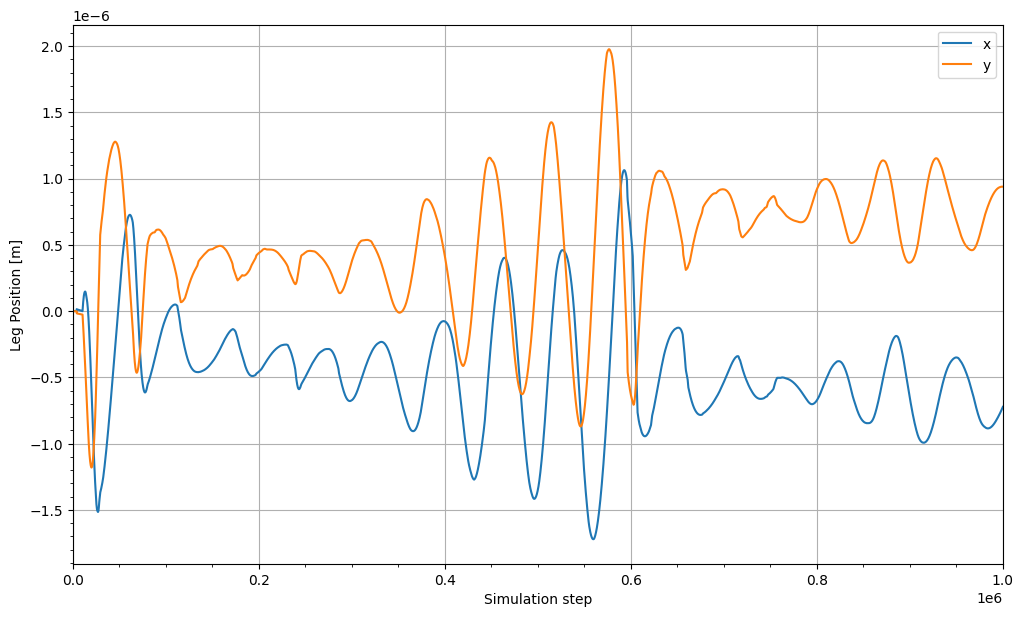

In [149]:
##plotting positions
plt.figure('Leg positions',  figsize = (12,7))
plt.plot(leg_positions_x, label='x')
plt.plot(leg_positions_y, label='y')
plt.xlabel('Simulation step')
plt.ylabel('Leg Position [m]')
plt.legend()
plt.grid()
plt.minorticks_on()
#plt.ylim(leg_positions_x[0],0.6e-13)
plt.xlim(0,len(leg_positions_x))
#print(leg_positions_x[0])
plt.show()

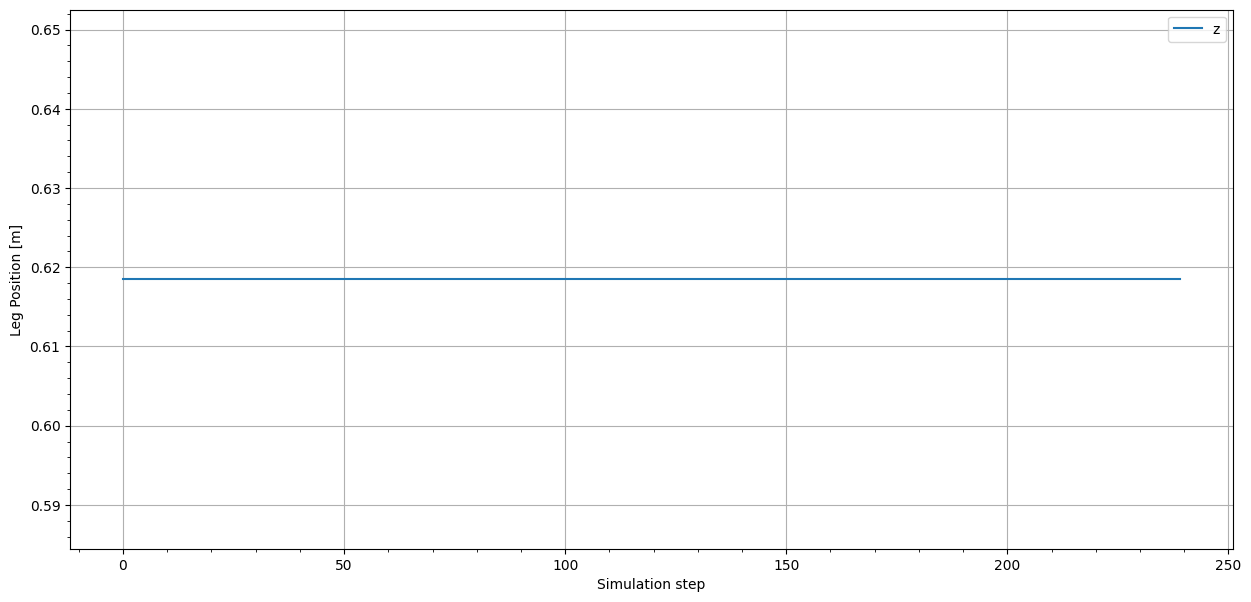

In [150]:
##plotting positions
plt.figure('Leg positions',  figsize = (15,7))
plt.plot(leg_position_z[100:340], label='z')
plt.xlabel('Simulation step')
plt.ylabel('Leg Position [m]')
plt.legend()
plt.grid()
plt.minorticks_on()
#plt.xlim(0,240)
min_plot = min(leg_position_z[100:340]) - 0.9e-14
max_plot = max(leg_position_z[100:340]) + 0.9e-14
#plt.ylim(0.6184900000818735,0.6184900000818800)
plt.show()

In [151]:
print(min(leg_position_z[100:340]))
print(max(leg_position_z[100:340]))

0.6184900000818775
0.6184900000818779


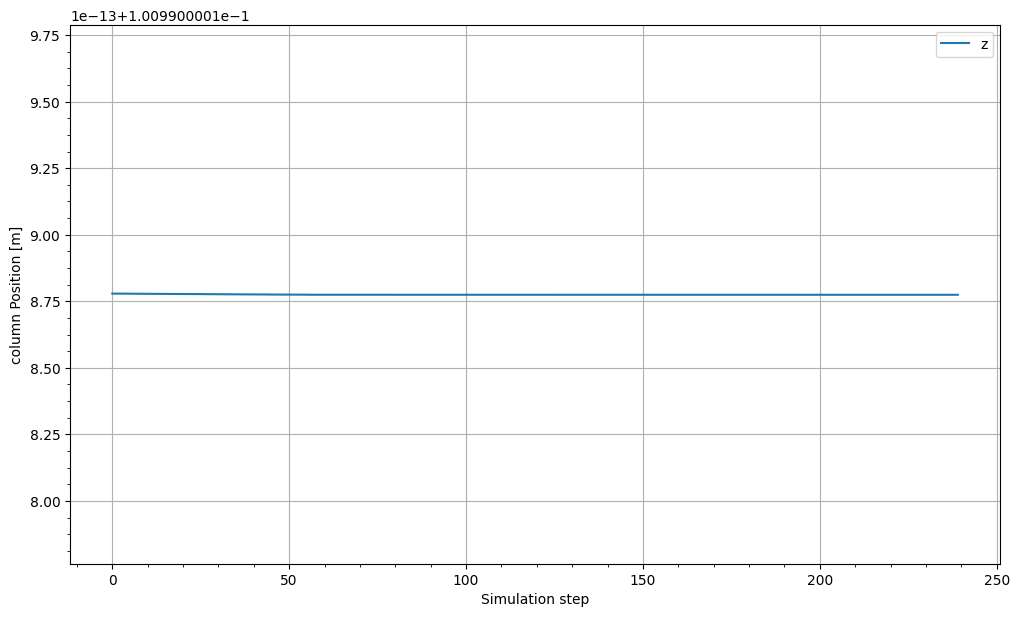

In [152]:

#plot column positions
plt.figure('column', figsize = (12,7))
#plt.plot(column_positions_x, label='x')
#plt.plot( column_positions_y, label='y')
plt.plot(column_positions_z[100:340], label='z')
plt.xlabel('Simulation step')
plt.ylabel('column Position [m]')
plt.legend()
plt.grid()
plt.minorticks_on()
#plt.xlim(0,240)
min_plot = min(column_positions_z[100:340]) - 1e-16
max_plot = max(column_positions_z[100:340]) + 1e-16
#plt.ylim(min_plot, max_plot)
plt.show()

In [153]:
#proviamo a verificare che stia fermo a botte di 240
print(min(column_positions_z[100:340]))
print(max(column_positions_z[100:340]))

0.10099000008187745
0.10099000008187792


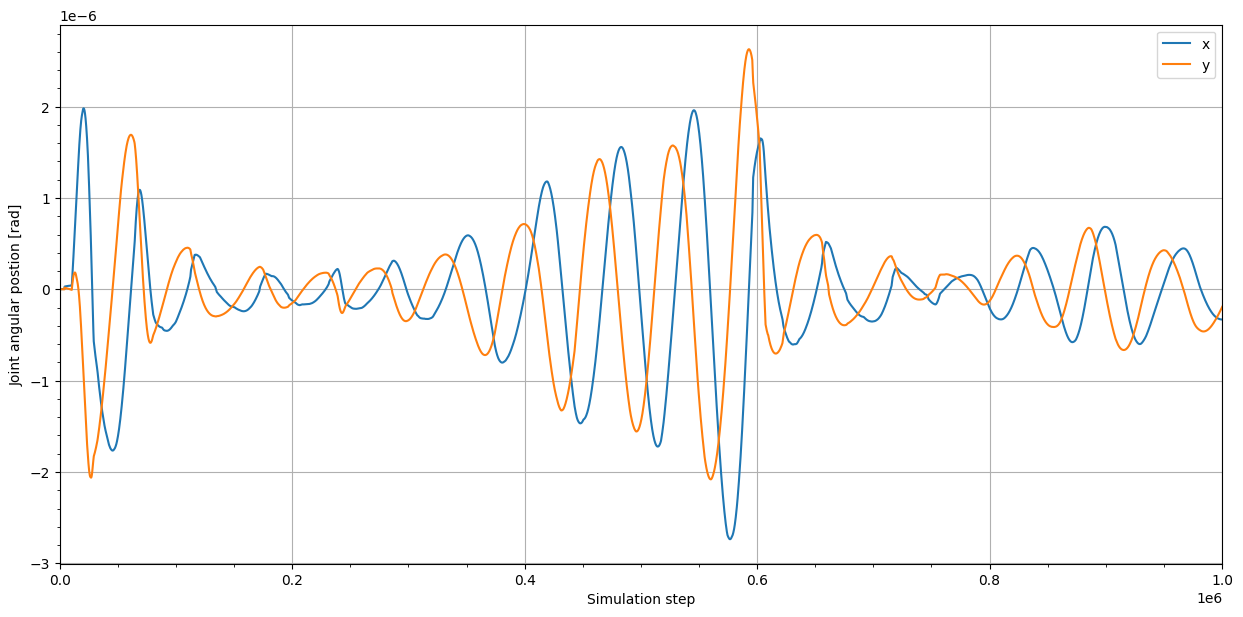

In [154]:
#plot elastic forces applied
plt.figure('Theta joint', figsize=(15,7))
plt.plot(theta_joint_x, label='x')
plt.plot(theta_joint_y, label='y')
plt.xlabel('Simulation step')
plt.ylabel('Joint angular postion [rad]')
plt.legend()
plt.grid()
#plt.ylim(-1e-15,3e-15)
#plt.xlim(300,400)
plt.xlim(0,len(leg_positions_x))
plt.minorticks_on()

In [155]:
print(theta_joint_y[1])
print(theta_joint_y[0])

1.5505441506080005e-15
-0.0


(0.0, 1000220.0)

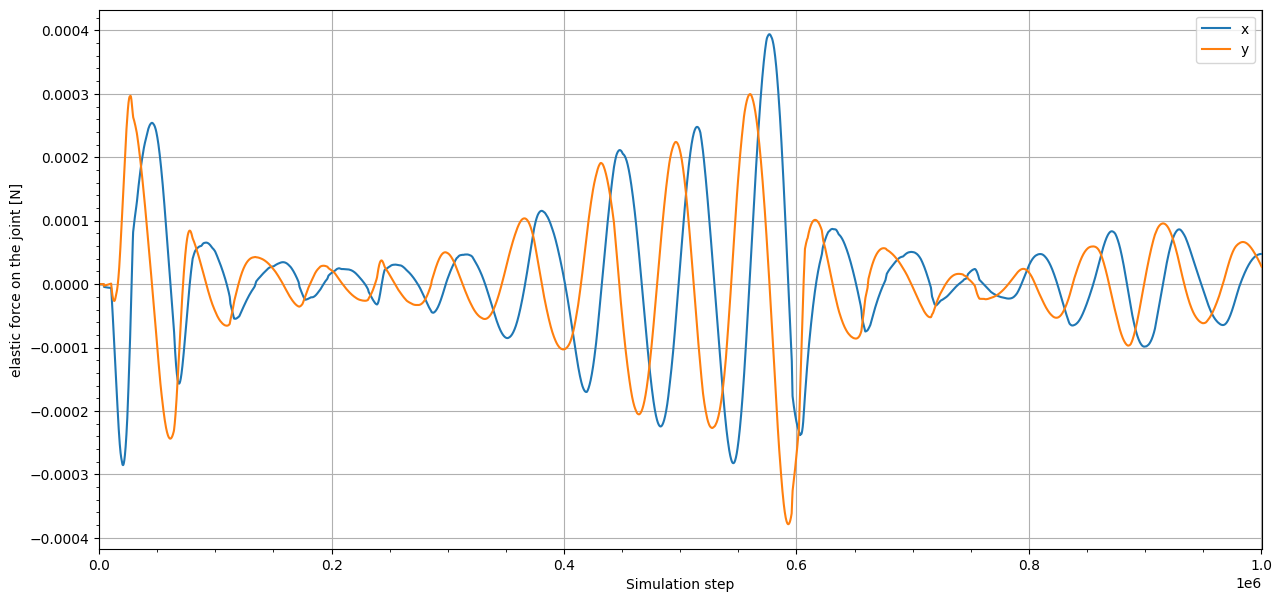

In [156]:
plt.figure('elastic force joint', figsize=(15,7))
plt.plot(force_x_joint, label='x')
plt.plot(force_y_joint, label='y')
plt.xlabel('Simulation step')
plt.ylabel('elastic force on the joint [N]')
plt.legend()
plt.grid()
plt.minorticks_on()
plt.xlim(0,len(leg_positions_x))

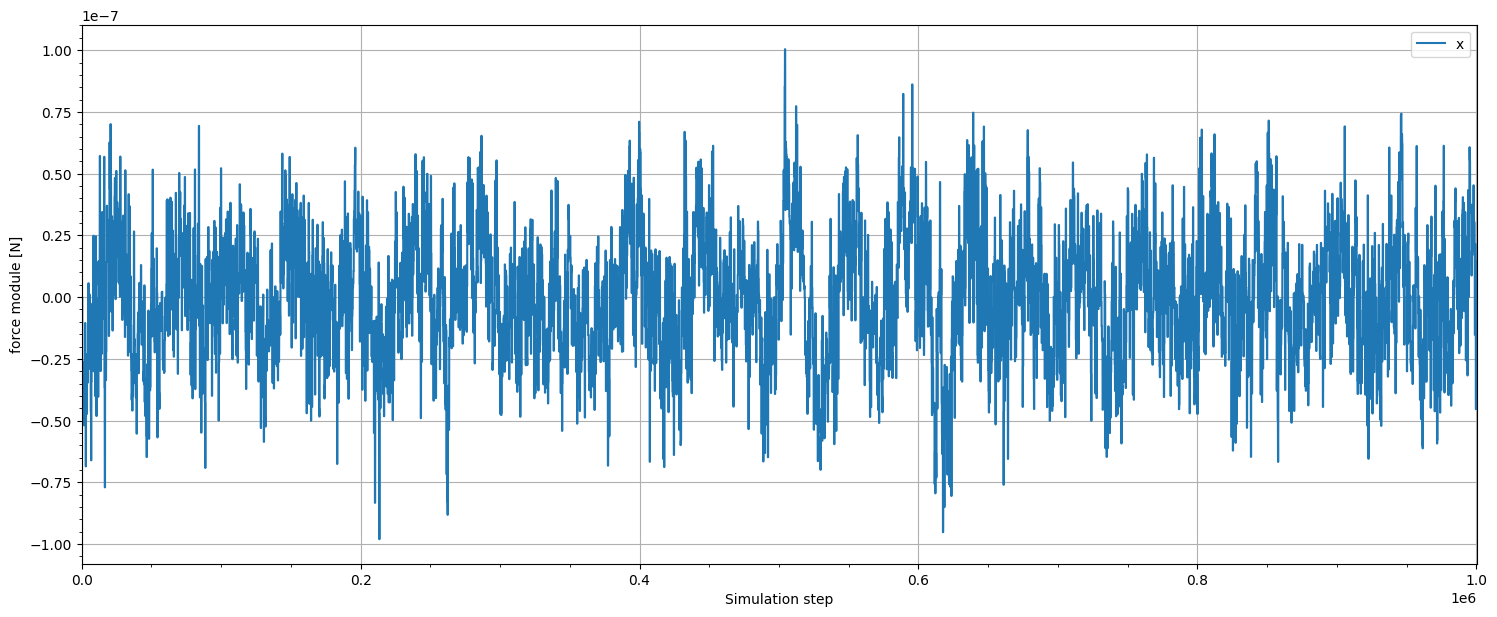

In [157]:
plt.figure('force module', figsize = (18,7))
plt.plot(force_module_botta, label='x')
plt.xlabel('Simulation step')
plt.ylabel('force module [N]')
plt.legend()
plt.grid()
plt.xlim(0,len(leg_positions_x))
plt.minorticks_on()
